In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve,confusion_matrix,auc, recall_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

from keras import layers
from keras import optimizers
from keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,  Conv2D, MaxPooling2D, Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import History, EarlyStopping, ModelCheckpoint

import sys
import tensorflow as tf
from tensorflow import keras 
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials, space_eval

In [3]:
def data():
    train = pd.read_csv('data/df_preprocessed_k5dist.csv')
    train = train.drop(['Unnamed: 0'], axis = 1)
    
    train_x = train.iloc[:,1:]
    train_y = train['class']
    
    input_size = train_x.shape[1:]
    
    X_train, X_valid, Y_train, Y_valid = train_test_split(train_x, train_y, test_size = 0.2, random_state = 0)

    return X_train, Y_train, X_valid, Y_valid, input_size

X_train, Y_train, X_valid, Y_valid, input_size = data()

print("Total number of datapoints in training: ", len(Y_train))
print("Total number of datapoints in Validation: ", len(Y_valid))

Total number of datapoints in training:  45600
Total number of datapoints in Validation:  11400


In [4]:
# loss 함수 정의

def cost(y_true, y_pred):
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_cost = 10*fp + 500*fn
    
    return total_cost


def cost_tensor(y_true, y_pred):
    
    mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred)
    total_cost = 10*mat[0][1] + 500*mat[1][0]
    
    return total_cost

- neg를 pos로 분류하는건 10달러의 비용
- pos를 neg로 분류하는건 500 달러의 비용

Cost = (10 * FP) + (500 * FN)

<img src = "https://t1.daumcdn.net/cfile/tistory/997188435BE05B0628">

## MLP - hyperparameter tuning

In [11]:
input_shape = input_size

space = {'choice': hp.choice('num_layers',
                    [ {'layers':'two', },
                    {'layers':'three',
                    'units3': hp.choice('units3', [1, 16, 32, 64, 78, 146]), 
                    'dropout3': hp.choice('dropout3', [0.0, 0.1, 0.2])}
                    ]),

            'units1': hp.choice('units1', [146, 256, 512, 1024]),
            'units2': hp.choice('units2', [16, 32, 64, 78, 146, 256, 512, 1024]),

            'dropout1': hp.choice('dropout1', [0.0, 0.1, 0.2]),
            'dropout2': hp.choice('dropout2', [0.0, 0.1, 0.2]),

            'batch_size' : hp.choice('batch_size', [16, 32, 64, 128]),
            'initializer': hp.choice('initializer', ['uniform', 'normal', 'lecun_uniform', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']),

            'epochs' :  hp.choice('epochs', [5, 10, 50, 100]),
            'optimizer': hp.choice('optimizer', ['sgd', 'adam', 'adagrad', 'adadelta', 'RMSprop']),
            'activation': hp.choice('activation', ['relu', 'sigmoid'])        
        }


def f_nn(params):   

    print ('Params testing: ', params)
    model = Sequential()
    model.add(Dense(params['units1'], input_shape = input_shape, kernel_initializer = params['initializer']))   
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dropout1']))

    model.add(Dense(params['units2'],kernel_initializer = params['initializer']))
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dropout2']))

    if params['choice']['layers'] == 'three':
        model.add(Dense(params['choice']['units3'], kernel_initializer = params['initializer'])) 
        model.add(Activation(params['activation']))
        model.add(Dropout(params['choice']['dropout3']))    

    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = params['optimizer'], metrics = ['accuracy'
                                                                           ,keras.metrics.Recall(name='recall')
                                                                           ,keras.metrics.FalsePositives(name='false_positives')
                                                                           ,keras.metrics.FalseNegatives(name='false_negatives')])

    es = EarlyStopping(monitor = 'val_recall', patience = 5)
    model.fit(X_train, Y_train, epochs=params['epochs'], batch_size=params['batch_size'], verbose = 0, callbacks = es, validation_data = (X_valid, Y_valid))

    Y_pred = model.predict(X_valid)
    total_cost = cost(Y_valid, Y_pred.round())
    print('cost:', total_cost)
    
    sys.stdout.flush() 
    return {'loss': total_cost, 'status': STATUS_OK}


trials = Trials()
best = fmin(f_nn, space, algo=tpe.suggest, max_evals=50, trials=trials)
print('best: ', best)

Params testing:                                       
{'activation': 'relu', 'batch_size': 64, 'choice': {'layers': 'two'}, 'dropout1': 0.1, 'dropout2': 0.0, 'epochs': 100, 'initializer': 'he_normal', 'optimizer': 'RMSprop', 'units1': 1024, 'units2': 146}
cost:                                                 
40810                                                 
Params testing:                                                      
{'activation': 'relu', 'batch_size': 64, 'choice': {'layers': 'two'}, 'dropout1': 0.0, 'dropout2': 0.0, 'epochs': 50, 'initializer': 'normal', 'optimizer': 'sgd', 'units1': 1024, 'units2': 1024}
cost:                                                                
39340                                                                
Params testing:                                                      
{'activation': 'relu', 'batch_size': 16, 'choice': {'dropout3': 0.2, 'layers': 'three', 'units3': 32}, 'dropout1': 0.1, 'dropout2': 0.2, 'epochs': 5, 'initial

In [13]:
space_eval(space, best)

{'activation': 'relu',
 'batch_size': 128,
 'choice': {'layers': 'two'},
 'dropout1': 0.0,
 'dropout2': 0.2,
 'epochs': 10,
 'initializer': 'lecun_uniform',
 'optimizer': 'adam',
 'units1': 256,
 'units2': 32}

## MLP model

In [5]:
input_shape = input_size

model = Sequential()
model.add(Dense(256, input_shape = input_shape, kernel_initializer = 'lecun_uniform')) 
model.add(Activation('relu'))

model.add(Dense(32, kernel_initializer = 'lecun_uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.2))
    
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss ='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'
                                                                       ,keras.metrics.Recall(name='recall')
                                                                       ,keras.metrics.FalsePositives(name='false_positives')
                                                                       ,keras.metrics.FalseNegatives(name='false_negatives')])

es = EarlyStopping(monitor = 'val_recall', patience = 10)
hist = model.fit(X_train, Y_train, epochs = 15, batch_size = 128, verbose = 0, callbacks = es, validation_data = (X_valid, Y_valid))

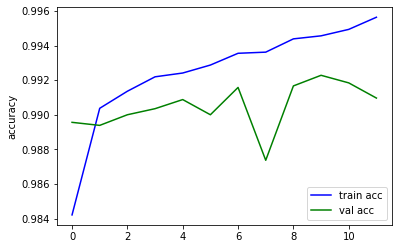

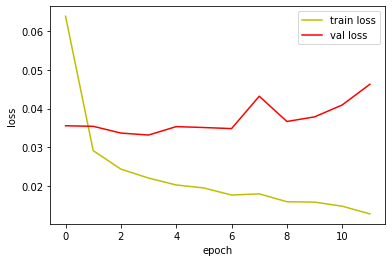

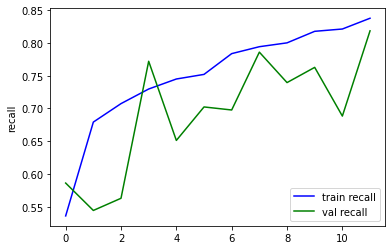

In [15]:
plt.plot(hist.history['accuracy'], 'b', label='train acc')
plt.plot(hist.history['val_accuracy'], 'g', label='val acc')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(hist.history['loss'], 'y', label='train loss')
plt.plot(hist.history['val_loss'], 'r', label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

plt.plot(hist.history['recall'], 'b', label='train recall')
plt.plot(hist.history['val_recall'], 'g', label='val recall')
plt.ylabel('recall')
plt.legend(loc='lower right')
plt.show()

In [16]:
Y_pred = model.predict(X_valid)
cm = confusion_matrix(Y_valid, Y_pred.round())
print(cm)

cm = pd.DataFrame(cm.reshape((1,4)), columns=['tn', 'fp', 'fn', 'tp'])
total_cost = 10*cm.fp + 500*cm.fn

print(f'Total cost is: {float(total_cost.values[0])}')

[[11121    64]
 [   39   176]]
Total cost is: 20140.0


In [17]:
20140 / 11400

1.7666666666666666

Text(0.5, 1.0, 'Confusion Matrix')

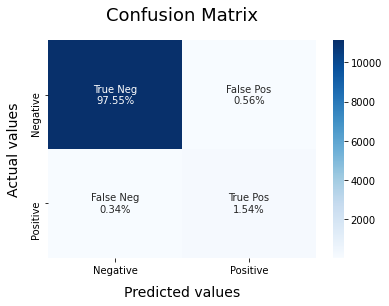

In [18]:
cf_matrix = confusion_matrix(Y_valid, Y_pred.round())

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
            xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

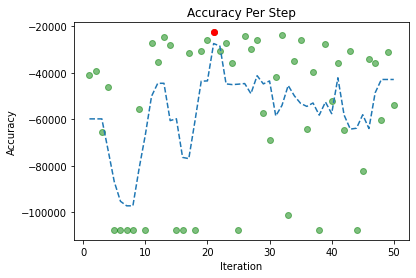

In [19]:
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

y = np.array([ -t['loss'] for t in trials.results])
x = np.arange(1, len(y) + 1, 1)

y_max = np.max(y)
best_y = y[y == y_max]
best_y_xs = x[y == y_max]

#just to calculate a locally weighted average
reg = KNeighborsRegressor()
reg.fit(x.reshape(-1, 1), y)
preds = reg.predict(x.reshape(-1, 1))

plt.plot(x, y, 'go', alpha=0.5)
plt.plot(best_y_xs, best_y, 'ro')
plt.plot(x, preds, '--')

plt.ylabel('Accuracy')
plt.xlabel('Iteration')
plt.title('Accuracy Per Step')
plt.show()

## Test set에 적용

In [8]:
test = pd.read_csv('data/test_preprocessed_k5dist.csv')
test = test.drop(['Unnamed: 0'], axis = 1)

Y_pred = model.predict(test)

In [21]:
prediction = pd.DataFrame(Y_pred.round(), columns = {"Prediction"})

In [25]:
result = pd.concat([test, prediction], axis = 1)

In [33]:
result.to_csv('Prediction_result.csv')